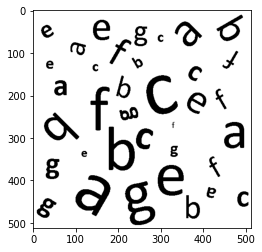

In [74]:
import cv2
import matplotlib.pyplot as plt

#leer la imagen (en formato BGR)
img =cv2.imread('sopa_letras.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#despliega la imagen
plt.imshow(img)
plt.show()

In [75]:
#dimensiones de la imagen
dimensiones = img.shape
print('Numero de fila:',dimensiones[0])
print('Numero de colas:',dimensiones[1])
print('Numero de canales:',dimensiones[2])

Numero de fila: 512
Numero de colas: 512
Numero de canales: 3


Hay 36 regiones en la imagen


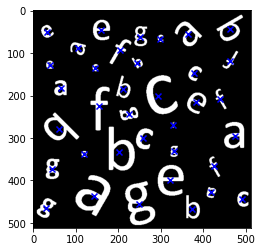

In [138]:
##extracción de datos de cada letra
import numpy as np
from skimage.measure import regionprops, label

#binarizacion
ret, bw = cv2.threshold(gray, 125,255,cv2.THRESH_BINARY_INV)


#etiquetamos cada imagen
label_bw = label(bw)
regiones = regionprops(label_image=label_bw)
num_figuras =  len(regiones)
print(f'Hay {num_figuras} regiones en la imagen')

plt.figure()
plt.imshow(bw, cmap='gray')

# para cada region, extraemos la información de coordenadas
for region in regionprops(label_image= label_bw):
   #para cada region extraemos información especifica
    cxy = region.centroid
    plt.scatter(cxy[1], cxy[0], marker='x', color='blue')

plt.show()
A= np.zeros((num_figuras,9))

  

In [147]:
 from math import copysign, log10
 from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
 
 #Momento
def mrs(r, s, I, J):
    i=I**r
    j=J**s
    return np.sum(i*j)

# Momento central
def  m_central(r, s, I, J):
    m00 = mrs(0,0,I,J)
    m10 = mrs(1,0,I,J)
    m01 = mrs(0,1,I,J)
    ci = m10/m00
    cj = m01/m00
    i = (I-ci)**r
    j = (J-cj)**s

    return sum(i*j)

# Momentos de Hu
def hu(I, J):
    H= np.zeros(7)
    eta11 = eta(1,1,I,J)
    eta12 = eta(1,2,I,J)
    eta20 = eta(2,0,I,J)
    eta21 = eta(2,1,I,J)
    eta02 = eta(0,2,I,J)
    eta03 = eta(0,3,I,J)
    eta30 = eta(3,0,I,J)

    H[0] = eta20+eta02
    H[1] = (eta20-eta02)**2 + 4*eta11**2
    H[2] = (eta30-3*eta12)**2+(3*eta21-eta03)**2
    H[3] = (eta30+eta12)**2+(eta21+eta03)**2
    H[4] =(eta30-3*eta12)*(eta30+eta12)*( (eta30+eta12)**2-3*(eta21+eta03)**2)+(3*eta21-eta03)*(eta21+eta03)*(3* (eta30+eta12)**2- (eta21+eta03)**2 )
    H[5] = (eta20-eta02)*((eta30+eta12)**2-(eta21+eta03)**2+ 4*eta11*(eta30+eta12)*(eta21+eta03))
    H[6] = (3*eta21-eta03)*(eta30+eta12)*((eta30+eta12)**2-3*(eta21+eta03)**2)+(eta30-3*eta12)*(eta21+eta03)* (3*(eta30+eta12)**2-(eta21+eta03)**2)
    return H

# Funcion eta
def eta(r, s, I, J):

    t = (r+s)/2 + 1
    a =  m_central(r,s,I,J)
    b =  m_central(0,0,I,J)

    return a/(b**t)


#separando cada imagen
 l=0
 for region in regiones:
  sub_imagen = region.image.astype('uint8')
  contornos, h = cv2.findContours(sub_imagen, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  matriz_contornos = np.vstack(contornos[0])
  
  #momento de Hu:
  cij = np.argwhere(sub_imagen==1)
  huMoments = hu(cij[:,0], cij[:,1])
  m00 = mrs(0,0,cij[:,0], cij[:,1])
  m10 = mrs(1,0,cij[:,0], cij[:,1])
  m01 = mrs(0,1,cij[:,0], cij[:,1])
  x = cij[:,0]
  y = cij[:,1]

  
  ci = m10/m00
  cj = m01/m00
  #normalizamos momentos
  for k in range(0,5):
    huMoments[k]=-1** copysign(1.0,huMoments[k]) * log10(np.abs(huMoments[k]))
    if k==0:
      m0=huMoments[k]
    if k==1:
      m1=huMoments[k]
    if k==2:
      m2=huMoments[k]
    if k==3:
      m3=huMoments[k]
    if k==4:
      m4=huMoments[k]
  
  #Complejidad de forma
  x , y =zip(*matriz_contornos)
  x=np.array(x).reshape(-1,1)
  y=np.array(y).reshape(-1,1)
  dd=np.sqrt((x-ci)**2+(y-cj)**2)
  dmean= np.mean(dd)
  f= m00/(dmean)**2

  
  #Perimetro
 #para el calculo del perimetro sumaremos la cantidad de puntos que componen el contorno de la figura.
  perimetro = np.shape(matriz_contornos)

  #Redondez
  R= 4*m00*np.pi/(perimetro[0])**2
  
  #Angulo elipse
  ell = EllipseModel()
  ell.estimate(cij)
 
  xc, yc, a, b, theta = ell.params


  #almacenando de datos en matriz
  A[l] = (m0,m1,m2,m3,m4,f,perimetro[0],R,theta)
  l= l+1
  




[[ 3.71225424e-01  1.58655944e+00  1.85787861e+00  3.13537175e+00
   5.63203687e+00  1.88496852e+00  1.87000000e+02  4.35541228e-01
   7.36922736e-01]
 [ 4.72206165e-01  2.40709338e+00  3.04040720e+00  3.38987568e+00
   6.81660123e+00  2.25446277e+00  1.86000000e+02  3.53061401e-01
   1.62724471e+00]
 [ 4.39794948e-01  1.92608558e+00  2.66138895e+00  3.34741278e+00
   6.43847466e+00  2.26552810e+00  2.02000000e+02  4.04671380e-01
   8.19257773e-01]
 [ 5.88410462e-01  2.78045914e+00  3.55948662e+00  3.79433344e+00
   7.89065490e+00  3.09121419e+00  1.06000000e+02  5.22293973e-01
   2.16914485e+00]
 [ 4.38636206e-01  1.49271215e+00  2.95206455e+00  3.79400076e+00
   7.17601269e+00  1.89331921e+00  1.68000000e+02  3.30365894e-01
  -6.32526028e-02]
 [ 5.34470679e-01  1.98634206e+00  2.59891709e+00  3.06952724e+00
   5.90374940e+00  2.72868912e+00  5.80000000e+01  4.89356287e-01
   1.57079633e+00]
 [ 2.72465099e-01  6.70930459e-01  1.59823023e+00  2.09178393e+00
   3.98414407e+00  2.0279914

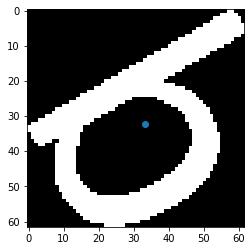

imagen 1 :


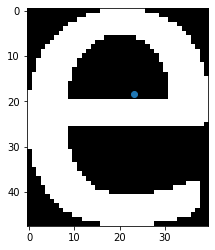

imagen 2 :


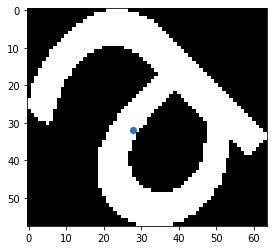

imagen 3 :


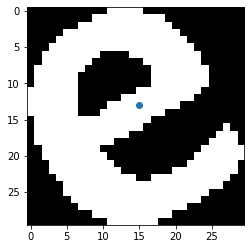

imagen 4 :


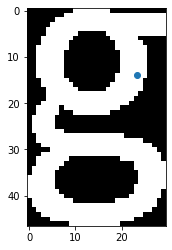

imagen 5 :


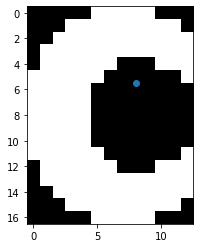

imagen 6 :


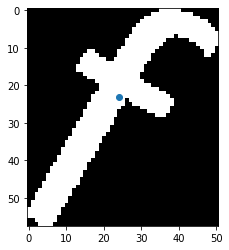

imagen 7 :


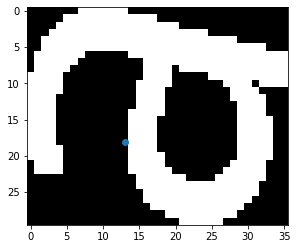

imagen 8 :


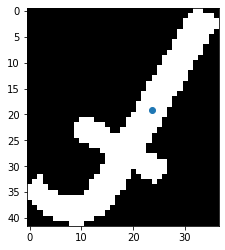

imagen 9 :


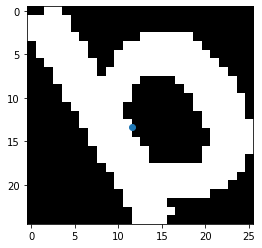

imagen 10 :


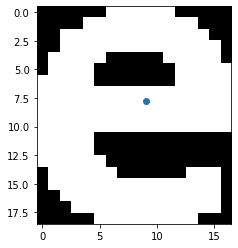

imagen 11 :


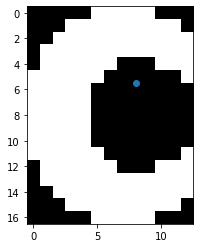

imagen 12 :


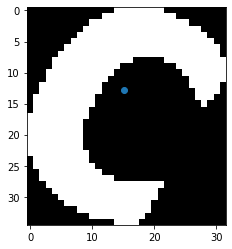

imagen 13 :


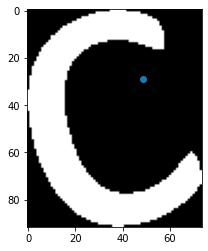

imagen 14 :


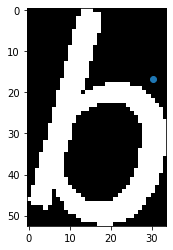

imagen 15 :


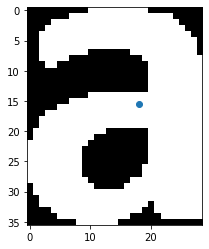

imagen 16 :


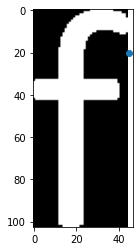

imagen 17 :


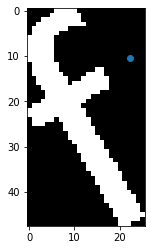

imagen 18 :


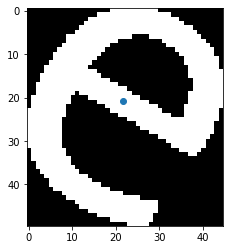

imagen 19 :


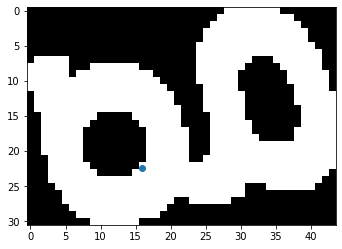

imagen 20 :


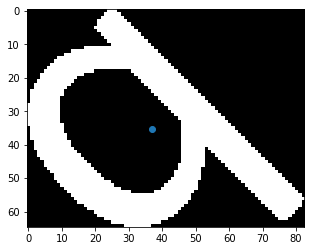

imagen 21 :


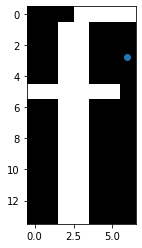

imagen 22 :


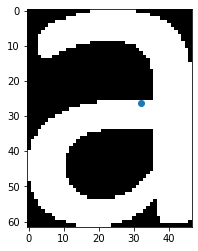

imagen 23 :


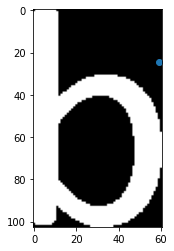

imagen 24 :


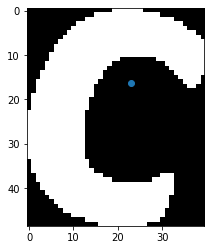

imagen 25 :


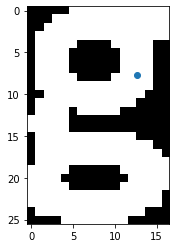

imagen 26 :


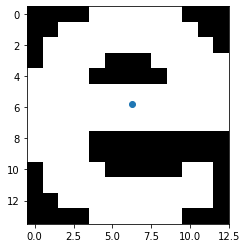

imagen 27 :


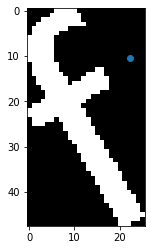

imagen 28 :


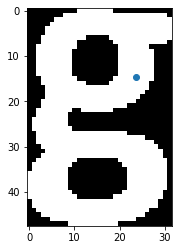

imagen 29 :


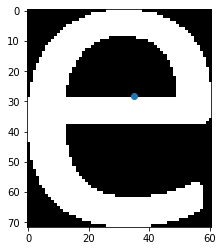

imagen 30 :


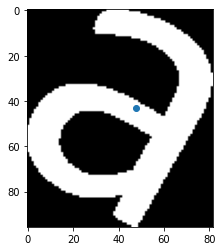

imagen 31 :


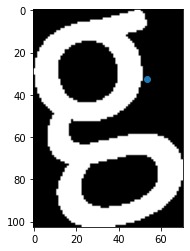

imagen 32 :


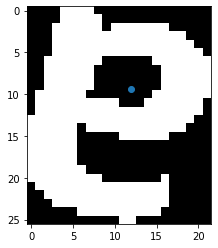

imagen 33 :


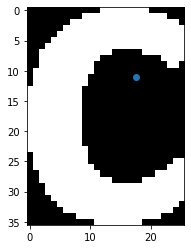

imagen 34 :


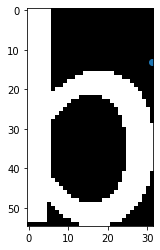

imagen 35 :


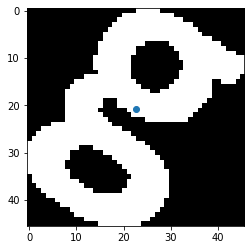

In [149]:
#imprimiendo la matriz
print(A)
#imprimiendo el centro de masa
l=0
for region in regiones:
  sub_imagen = region.image.astype('uint8')
  #Desplegando la informacion de cada imagen
  
  print('imagen', l,':' )
  l=l+1
  cij = np.argwhere(sub_imagen==1)

  m00 = mrs(0,0,cij[:,0], cij[:,1])
  m10 = mrs(1,0,cij[:,0], cij[:,1])
  m01 = mrs(0,1,cij[:,0], cij[:,1])
  
  ci = m10/m00
  cj = m01/m00

  plt.figure()
  plt.imshow(sub_imagen, cmap='gray')
  plt.scatter(ci,cj)
  plt.show()